In [1]:
import warnings

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import pandas as pd
import numpy as np
import random
import sc_toolbox
import pertpy 

import rpy2.rinterface_lib.callbacks
import anndata2ri
import logging

from rpy2.robjects import pandas2ri
from rpy2.robjects import r

sc.settings.verbosity = 0
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

pandas2ri.activate()
anndata2ri.activate()

pd.set_option('display.max_columns', None)

%load_ext rpy2.ipython

In [2]:
%%R
library(GSA)
library(msigdbr)
library(fgsea)
library(tidyverse) # includes ggplot2, for data visualisation. dplyr, for data manipulation.
library(RColorBrewer) # for a colourful plot

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [3]:
%%R

set.seed(42)

# Set up gene lists

In [4]:
%%R
msigdbr_species()

# A tibble: 20 × 2
   species_name                    species_common_name                          
   <chr>                           <chr>                                        
 1 Anolis carolinensis             Carolina anole, green anole                  
 2 Bos taurus                      bovine, cattle, cow, dairy cow, domestic cat…
 3 Caenorhabditis elegans          <NA>                                         
 4 Canis lupus familiaris          dog, dogs                                    
 5 Danio rerio                     leopard danio, zebra danio, zebra fish, zebr…
 6 Drosophila melanogaster         fruit fly                                    
 7 Equus caballus                  domestic horse, equine, horse                
 8 Felis catus                     cat, cats, domestic cat                      
 9 Gallus gallus                   bantam, chicken, chickens, Gallus domesticus 
10 Homo sapiens                    human                                        
11 Macaca

In [5]:
%%R

all_gene_sets = msigdbr(species = "human")
head(all_gene_sets)

# A tibble: 6 × 15
  gs_cat gs_subcat      gs_name        gene_symbol entrez_gene ensembl_gene   
  <chr>  <chr>          <chr>          <chr>             <int> <chr>          
1 C3     MIR:MIR_Legacy AAACCAC_MIR140 ABCC4             10257 ENSG00000125257
2 C3     MIR:MIR_Legacy AAACCAC_MIR140 ABRAXAS2          23172 ENSG00000165660
3 C3     MIR:MIR_Legacy AAACCAC_MIR140 ACTN4                81 ENSG00000130402
4 C3     MIR:MIR_Legacy AAACCAC_MIR140 ACTN4                81 ENSG00000282844
5 C3     MIR:MIR_Legacy AAACCAC_MIR140 ACVR1                90 ENSG00000115170
6 C3     MIR:MIR_Legacy AAACCAC_MIR140 ADAM9              8754 ENSG00000168615
# ℹ 9 more variables: human_gene_symbol <chr>, human_entrez_gene <int>,
#   human_ensembl_gene <chr>, gs_id <chr>, gs_pmid <chr>, gs_geoid <chr>,
#   gs_exact_source <chr>, gs_url <chr>, gs_description <chr>


In [6]:
%%R

# Get the MSigDB collections
collections <- msigdbr_collections()

# Print all rows of the tibble
print(collections, n = Inf)

# A tibble: 23 × 3
   gs_cat gs_subcat         num_genesets
   <chr>  <chr>                    <int>
 1 C1     ""                         299
 2 C2     "CGP"                     3384
 3 C2     "CP"                        29
 4 C2     "CP:BIOCARTA"              292
 5 C2     "CP:KEGG"                  186
 6 C2     "CP:PID"                   196
 7 C2     "CP:REACTOME"             1615
 8 C2     "CP:WIKIPATHWAYS"          664
 9 C3     "MIR:MIRDB"               2377
10 C3     "MIR:MIR_Legacy"           221
11 C3     "TFT:GTRD"                 518
12 C3     "TFT:TFT_Legacy"           610
13 C4     "CGN"                      427
14 C4     "CM"                       431
15 C5     "GO:BP"                   7658
16 C5     "GO:CC"                   1006
17 C5     "GO:MF"                   1738
18 C5     "HPO"                     5071
19 C6     ""                         189
20 C7     "IMMUNESIGDB"             4872
21 C7     "VAX"                      347
22 C8     ""                         7

In [7]:
%%R

#Retrieve human H (hallmark gene sets) 
msigdbr_df <- msigdbr(species = "human", category = "H")


head(msigdbr_df)

# A tibble: 6 × 15
  gs_cat gs_subcat gs_name               gene_symbol entrez_gene ensembl_gene   
  <chr>  <chr>     <chr>                 <chr>             <int> <chr>          
1 H      ""        HALLMARK_ADIPOGENESIS ABCA1                19 ENSG00000165029
2 H      ""        HALLMARK_ADIPOGENESIS ABCB8             11194 ENSG00000197150
3 H      ""        HALLMARK_ADIPOGENESIS ACAA2             10449 ENSG00000167315
4 H      ""        HALLMARK_ADIPOGENESIS ACADL                33 ENSG00000115361
5 H      ""        HALLMARK_ADIPOGENESIS ACADM                34 ENSG00000117054
6 H      ""        HALLMARK_ADIPOGENESIS ACADS                35 ENSG00000122971
# ℹ 9 more variables: human_gene_symbol <chr>, human_entrez_gene <int>,
#   human_ensembl_gene <chr>, gs_id <chr>, gs_pmid <chr>, gs_geoid <chr>,
#   gs_exact_source <chr>, gs_url <chr>, gs_description <chr>


In [8]:
%%R

pathwaysH = split(x = msigdbr_df$gene_symbol, f = msigdbr_df$gs_name)
head(pathwaysH)

$HALLMARK_ADIPOGENESIS
  [1] "ABCA1"    "ABCB8"    "ACAA2"    "ACADL"    "ACADM"    "ACADS"   
  [7] "ACLY"     "ACO2"     "ACOX1"    "ADCY6"    "ADIG"     "ADIPOQ"  
 [13] "ADIPOR2"  "ADIPOR2"  "AGPAT3"   "AIFM1"    "AK2"      "ALDH2"   
 [19] "ALDOA"    "ANGPT1"   "ANGPTL4"  "APLP2"    "APOE"     "ARAF"    
 [25] "ARL4A"    "ATL2"     "ATP1B3"   "ATP5PO"   "BAZ2A"    "BCKDHA"  
 [31] "BCL2L13"  "BCL6"     "C3"       "CAT"      "CAVIN1"   "CAVIN2"  
 [37] "CCNG2"    "CD151"    "CD302"    "CD36"     "CDKN2C"   "CHCHD10" 
 [43] "CHCHD10"  "CHCHD10"  "CHUK"     "CIDEA"    "CMBL"     "CMPK1"   
 [49] "COL15A1"  "COL4A1"   "COQ3"     "COQ5"     "COQ9"     "COX6A1"  
 [55] "COX7B"    "COX8A"    "CPT2"     "CRAT"     "CS"       "CYC1"    
 [61] "CYP4B1"   "DBT"      "DDT"      "DDT"      "DECR1"    "DGAT1"   
 [67] "DGAT1"    "DGAT1"    "DHCR7"    "DHRS7"    "DHRS7B"   "DLAT"    
 [73] "DLD"      "DNAJB9"   "DNAJC15"  "DRAM2"    "ECH1"     "ECH1"    
 [79] "ECHS1"    "ELMOD3"   "ELOVL6"   "E

In [9]:
%%R

options(ports=8888)

# AL/CAL_MOL

In [10]:
%%R

# Replace the file path with the actual path if the file is not in the current directory
df <- read.csv("./files/MOL_GvC_WM_v_AL_dream.csv")
head(df)  # Display the first few rows of the data frame to confirm it's loaded correctly

     gene  gene.1     logFC  AveExpr         t      P.Value    adj.P.Val
1  FCHSD2  FCHSD2  1.581572 8.619551  13.88307 1.396070e-15 1.464058e-11
2  OPALIN  OPALIN  3.605888 6.701410  12.50188 7.294486e-14 3.824864e-10
3  KCNAB1  KCNAB1  3.377023 5.981777  10.71410 1.899705e-12 5.260495e-09
4  INPP5F  INPP5F -2.975575 6.433039 -11.69498 2.258445e-12 5.260495e-09
5 ST8SIA5 ST8SIA5 -3.377412 5.242225 -10.60200 2.508103e-12 5.260495e-09
6   KCNH8   KCNH8  1.035896 9.884221  10.43234 3.830866e-12 6.695715e-09
          B
1 25.108251
2 13.909813
3 18.037926
4  9.405133
5 18.047799
6 17.637203


In [11]:
%%R

df <- df %>%
  mutate(logFC_rev = logFC * -1)

In [12]:
%%R
# Calculate the number of genes with adj.P.Val < 0.05 and |logFC| > 1
genes_up <- df[df$adj.P.Val < 0.05 & df$logFC_rev > 0.585, ]
num_genes_up <- nrow(genes_up)

# Print the number of significant genes
print(num_genes_up)

genes_up_sorted <- genes_up[order(genes_up$logFC_rev, decreasing = TRUE), ]

# View the head of the significant genes data frame
head(genes_up_sorted)

[1] 1012
        gene   gene.1     logFC  AveExpr         t      P.Value    adj.P.Val
46      GBP2     GBP2 -6.123773 2.562658 -8.010834 1.288585e-08 2.880693e-06
161     EGR1     EGR1 -5.367430 2.613755 -6.039521 1.031502e-06 6.718855e-05
72     ANXA2    ANXA2 -5.346736 2.113728 -7.432187 5.560261e-08 8.098675e-06
71      EMP1     EMP1 -5.101796 1.473179 -7.168967 5.435671e-08 8.028716e-06
104 SERPINE1 SERPINE1 -5.038207 1.175630 -6.639030 2.644556e-07 2.666679e-05
83    LGALS3   LGALS3 -4.836364 1.383500 -7.432317 1.213868e-07 1.533715e-05
           B logFC_rev
46  4.909171  6.123773
161 4.278097  5.367430
72  1.977122  5.346736
71  4.044970  5.101796
104 4.811449  5.038207
83  6.061271  4.836364


In [13]:
%%R
# Calculate the number of genes with adj.P.Val < 0.05 and |logFC| > 1
genes_down <- df[df$adj.P.Val < 0.05 & df$logFC_rev < -0.585, ]
num_genes_down <- nrow(genes_down)

# Print the number of significant genes
print(num_genes_down)

genes_down_sorted <- genes_down[order(genes_down$logFC_rev, decreasing = FALSE), ]

# View the head of the significant genes data frame
head(genes_down_sorted)

[1] 610
         gene    gene.1    logFC  AveExpr         t      P.Value    adj.P.Val
69   TMEM132B  TMEM132B 4.204333 3.570902  6.995350 4.500053e-08 6.839429e-06
139    ATP8A2    ATP8A2 3.931424 4.591422  6.089010 7.265067e-07 5.405702e-05
34      PLCL2     PLCL2 3.647650 3.876999  7.801878 5.460501e-09 1.658317e-06
2      OPALIN    OPALIN 3.605888 6.701410 12.501880 7.294486e-14 3.824864e-10
3      KCNAB1    KCNAB1 3.377023 5.981777 10.714100 1.899705e-12 5.260495e-09
66  LINC01299 LINC01299 2.913095 3.593926  7.201779 3.691468e-08 5.865520e-06
            B logFC_rev
69   7.056825 -4.204333
139  5.861247 -3.931424
34   6.216093 -3.647650
2   13.909813 -3.605888
3   18.037926 -3.377023
66   5.428372 -2.913095


In [14]:
%%R

dim(df)

[1] 10487     9


In [15]:
%%R

my_genes <- df$gene
head(my_genes)

[1] "FCHSD2"  "OPALIN"  "KCNAB1"  "INPP5F"  "ST8SIA5" "KCNH8"  


In [16]:
%%R
# Check column names in the dataframe
colnames(df)

[1] "gene"      "gene.1"    "logFC"     "AveExpr"   "t"         "P.Value"  
[7] "adj.P.Val" "B"         "logFC_rev"


In [17]:
%%R

# Filter the dataset for significant genes
filtered_df <- df[abs(df$logFC_rev) >= 0.585 & df$adj.P.Val < 0.05, ]

# Compute ranking score: sign(logFC) * -log10(P.Value)
filtered_df$ranking_score <- sign(filtered_df$logFC_rev) * -log10(filtered_df$P.Value)

# Assign names to the rankings
rankings <- filtered_df$ranking_score
names(rankings) <- filtered_df$gene

# Sort the rankings in descending order
rankings <- sort(rankings, decreasing = TRUE)

In [18]:
%%R

# Ensure the length of the gene column matches the length of rankings
length(df$gene) == length(rankings)

[1] FALSE


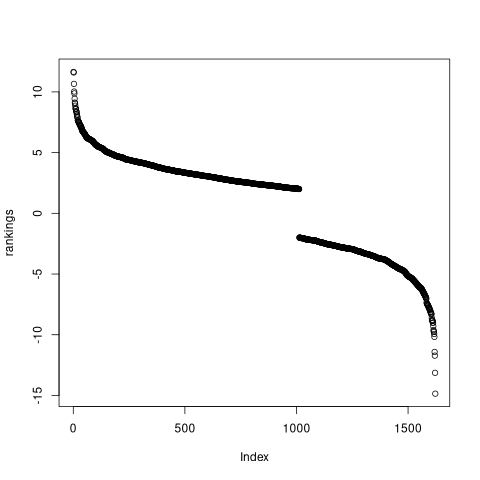

In [19]:
%%R

plot(rankings)

In [20]:
%%R

max(rankings)

[1] 11.64619


In [21]:
%%R

min(rankings)

[1] -14.85509


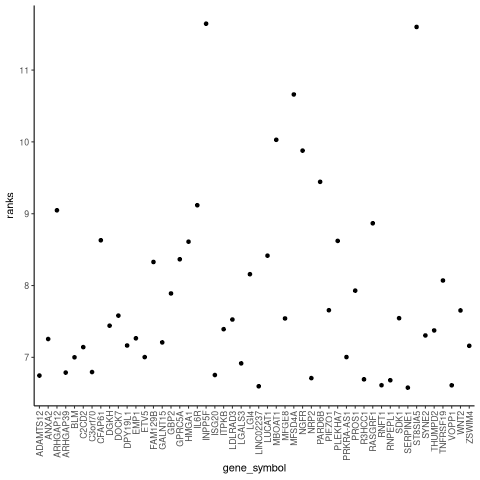

In [22]:
%%R

ggplot(data.frame(gene_symbol = names(rankings)[1:50], ranks = rankings[1:50]), aes(gene_symbol, ranks)) + 
    geom_point() +
    theme_classic() + 
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

# Figure out how to set up gene lists

In [23]:
%%R
fgsea_res <- fgsea(pathways = pathwaysH, 
                  stats    = rankings,
                  scoreType = 'std',
                  minSize  = 15,
                  maxSize  = 500)

In [24]:
%%R
fgsea_res

                                       pathway         pval        padj
                                        <char>        <num>       <num>
 1:                      HALLMARK_ADIPOGENESIS 1.528998e-01 0.282276599
 2:               HALLMARK_ALLOGRAFT_REJECTION 2.854610e-01 0.489361702
 3:                   HALLMARK_APICAL_JUNCTION 5.623902e-01 0.700336700
 4:                         HALLMARK_APOPTOSIS 4.661112e-03 0.022373336
 5:                        HALLMARK_COMPLEMENT 2.133940e-04 0.002560728
 6:                       HALLMARK_E2F_TARGETS 8.274648e-01 0.834549878
 7: HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION 3.261264e-04 0.002609011
 8:           HALLMARK_ESTROGEN_RESPONSE_EARLY 6.127946e-01 0.700336700
 9:            HALLMARK_ESTROGEN_RESPONSE_LATE 8.345499e-01 0.834549878
10:                    HALLMARK_G2M_CHECKPOINT 5.845070e-01 0.700336700
11:                   HALLMARK_HEME_METABOLISM 4.753521e-01 0.671085336
12:                           HALLMARK_HYPOXIA 4.919956e-02 0.11

In [25]:
%%R

dim(fgsea_res)

[1] 24  8


In [26]:
%%R
library(data.table)

fwrite(fgsea_res, file = "./files/fgsea_ALvWM_GvC_all.csv")

data.table 1.16.4 using 8 threads (see ?getDTthreads).  Latest news: r-datatable.com

Attaching package: ‘data.table’

The following objects are masked from ‘package:lubridate’:

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year

The following objects are masked from ‘package:dplyr’:

    between, first, last

The following object is masked from ‘package:purrr’:

    transpose



In [27]:
%%R

# Filter for significant results with padj < 0.05
fgsea_MOL2_significant <- fgsea_res %>% filter(padj < 0.1)
dim(fgsea_MOL2_significant)

[1] 9 8


In [28]:
%%R

head(fgsea_MOL2_significant)

                                      pathway         pval        padj
                                       <char>        <num>       <num>
1:                         HALLMARK_APOPTOSIS 4.661112e-03 0.022373336
2:                        HALLMARK_COMPLEMENT 2.133940e-04 0.002560728
3: HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION 3.261264e-04 0.002609011
4:               HALLMARK_IL2_STAT5_SIGNALING 1.876658e-02 0.056299729
5:             HALLMARK_INFLAMMATORY_RESPONSE 3.719097e-02 0.099175931
6:         HALLMARK_INTERFERON_ALPHA_RESPONSE 8.343393e-05 0.002002414
     log2err        ES      NES  size
       <num>     <num>    <num> <int>
1: 0.4070179 0.4546549 1.897157    21
2: 0.5188481 0.5544624 2.234759    19
3: 0.4984931 0.4927120 2.223225    25
4: 0.3524879 0.4206159 1.718310    20
5: 0.3217759 0.3950829 1.614002    20
6: 0.5384341 0.5883490 2.280342    17
                                     leadingEdge
                                          <list>
1:         EMP1,LGALS3,ISG20,I

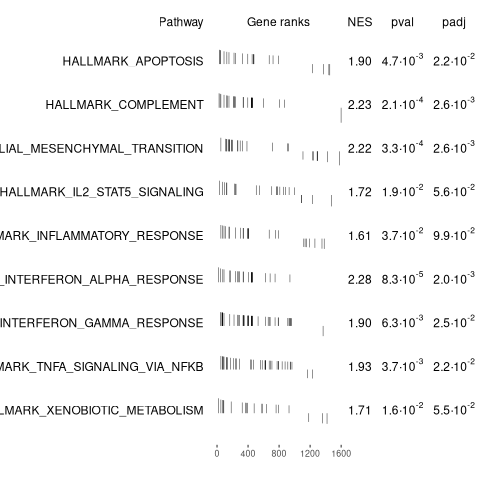

In [29]:
%%R

plotGseaTable(pathwaysH[fgsea_MOL2_significant$pathway], 
              rankings, 
              fgsea_MOL2_significant, 
              gseaParam = 0.5)

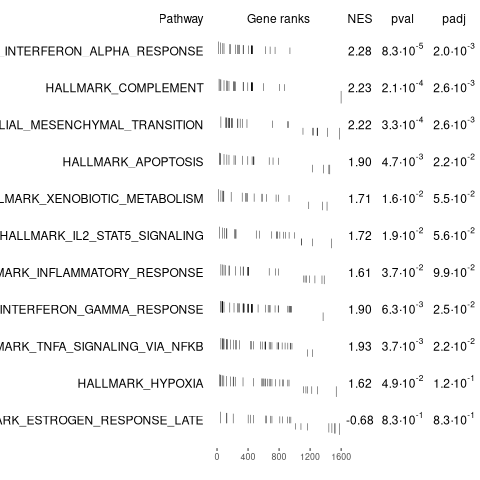

In [30]:
%%R

topUp <- fgsea_res %>% 
    filter(ES > 0) %>% 
    top_n(10, wt=-padj)
topDown <- fgsea_res %>% 
    filter(ES < 0) %>% 
    top_n(10, wt=-padj)
topPathways <- bind_rows(topUp, topDown) %>% 
    arrange(-ES)
plotGseaTable(pathwaysH[topPathways$pathway], 
              rankings, 
              fgsea_res, 
              gseaParam = 0.5)

In [31]:
%%R

collapsedPathways <- collapsePathways(fgsea_MOL2_significant[order(pval)][padj < 0.1], 
                                      pathwaysH, rankings)

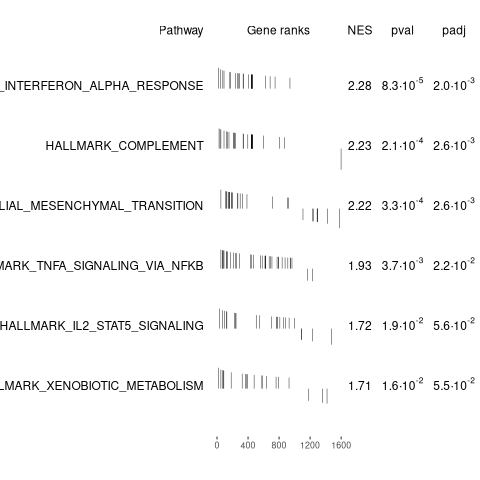

In [32]:
%%R

mainPathways <- fgsea_MOL2_significant[pathway %in% collapsedPathways$mainPathways][
                         order(-NES), pathway]
plotGseaTable(pathwaysH[mainPathways], rankings, fgsea_MOL2_significant, 
              gseaParam = 0.5)

In [33]:
%%R

fgseaResTidy <- fgsea_res %>%
  as_tibble() %>%
  arrange(desc(NES))

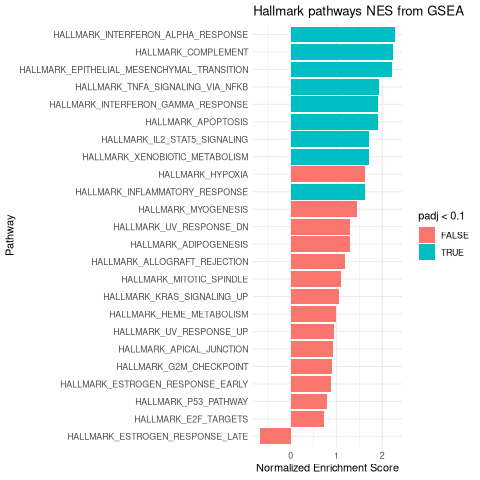

In [34]:
%%R

ggplot(fgseaResTidy, aes(reorder(pathway, NES), NES)) +
  geom_col(aes(fill=padj<0.1)) +
  coord_flip() +
  labs(x="Pathway", y="Normalized Enrichment Score",
       title="Hallmark pathways NES from GSEA") + 
  theme_minimal()


#https://stephenturner.github.io/deseq-to-fgsea/#using_the_fgsea_package

In [35]:
%%R

# Subset significant results
fgseaResSignificant <- fgseaResTidy[fgseaResTidy$padj < 0.1, ]

# Select columns to display and sort by padj
fgseaResSignificant <- fgseaResSignificant[, c("pathway", "padj", "NES", "size")]
fgseaResSignificant <- fgseaResSignificant[order(fgseaResSignificant$padj), ]

# Print the table
head(fgseaResSignificant)

# A tibble: 6 × 4
  pathway                                       padj   NES  size
  <chr>                                        <dbl> <dbl> <int>
1 HALLMARK_INTERFERON_ALPHA_RESPONSE         0.00200  2.28    17
2 HALLMARK_COMPLEMENT                        0.00256  2.23    19
3 HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION 0.00261  2.22    25
4 HALLMARK_TNFA_SIGNALING_VIA_NFKB           0.0223   1.93    36
5 HALLMARK_APOPTOSIS                         0.0224   1.90    21
6 HALLMARK_INTERFERON_GAMMA_RESPONSE         0.0254   1.90    31


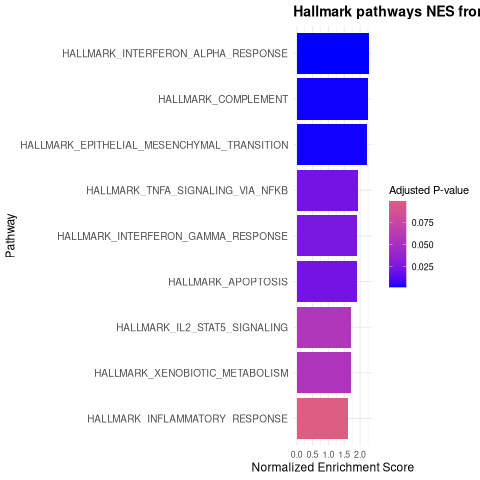

In [36]:
%%R

# Create the ggplot with a color scale for padj
ggplot(fgseaResSignificant, aes(reorder(pathway, NES), NES)) +
  geom_col(aes(fill = padj)) +
  coord_flip() +
  scale_fill_gradient(low = "#0000FF", high = "#de5d83", na.value = "black", name = "Adjusted P-value") +
  labs(x = "Pathway", y = "Normalized Enrichment Score",
       title = "Hallmark pathways NES from GSEA") +
  theme_minimal() +
  theme(
    axis.text.y = element_text(size = 10),
    axis.title = element_text(size = 12),
    plot.title = element_text(size = 14, face = "bold")
  )

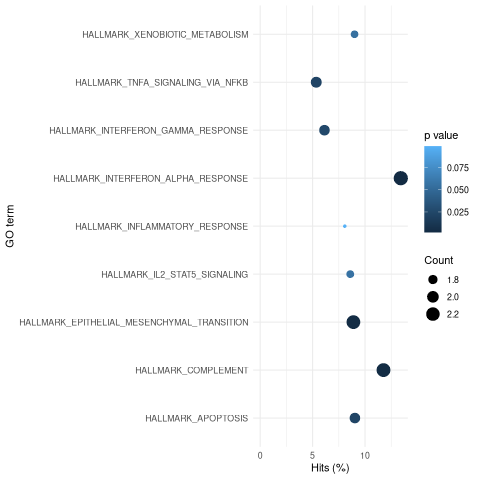

In [37]:
%%R

# Calculate hits percentage (if 'numDEInCat' and 'numInCat' equivalent are 'NES' and 'size')
fgseaResSignificant <- fgseaResSignificant %>%
  mutate(hitsPerc = NES * 100 / size)

# Ensure the columns 'padj' and 'NES' are present for the plot
fgseaResSignificant <- fgseaResSignificant %>%
  rename(term = pathway, over_represented_pvalue = padj, numDEInCat = NES)

# Create the plot
ggplot(fgseaResSignificant, aes(x = hitsPerc, y = term, colour = over_represented_pvalue, size = numDEInCat)) +
  geom_point() +
  expand_limits(x = 0) +
  labs(x = "Hits (%)", y = "GO term", colour = "p value", size = "Count") +
  theme_minimal()

#https://bioinformatics-core-shared-training.github.io/cruk-summer-school-2018/RNASeq2018/html/06_Gene_set_testing.nb.html

In [38]:
%%R

# Subset significant results
fgseaResSignificant <- fgseaResTidy[fgseaResTidy$padj < 0.1, ]

# Select columns to display and sort by padj
fgseaResSignificant <- fgseaResSignificant[, c("pathway", "padj", "NES", "size")]
fgseaResSignificant <- fgseaResSignificant[order(fgseaResSignificant$padj), ]

# Print the table
head(fgseaResSignificant)

# A tibble: 6 × 4
  pathway                                       padj   NES  size
  <chr>                                        <dbl> <dbl> <int>
1 HALLMARK_INTERFERON_ALPHA_RESPONSE         0.00200  2.28    17
2 HALLMARK_COMPLEMENT                        0.00256  2.23    19
3 HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION 0.00261  2.22    25
4 HALLMARK_TNFA_SIGNALING_VIA_NFKB           0.0223   1.93    36
5 HALLMARK_APOPTOSIS                         0.0224   1.90    21
6 HALLMARK_INTERFERON_GAMMA_RESPONSE         0.0254   1.90    31


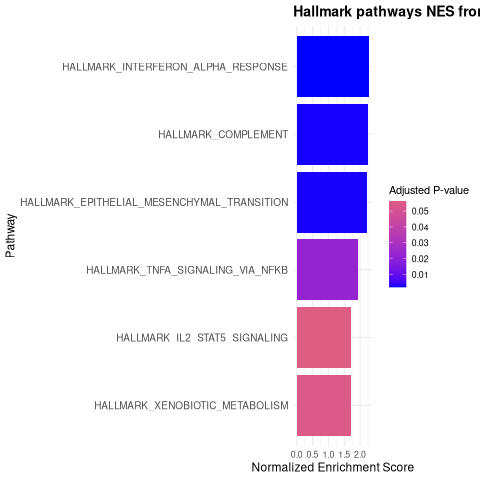

In [39]:
%%R

# Filter fgseaResSignificant to include only the main pathways from collapsedPathways
filtered_fgseaResSignificant <- fgseaResSignificant %>%
  filter(pathway %in% collapsedPathways$mainPathways)

# Create the ggplot with a color scale for padj
ggplot(filtered_fgseaResSignificant, aes(reorder(pathway, NES), NES)) +
  geom_col(aes(fill = padj)) +
  coord_flip() +
  scale_fill_gradient(low = "#0000FF", high = "#de5d83", na.value = "black", name = "Adjusted P-value") +
  labs(x = "Pathway", y = "Normalized Enrichment Score",
       title = "Hallmark pathways NES from GSEA") +
  theme_minimal() +
  theme(
    axis.text.y = element_text(size = 10),
    axis.title = element_text(size = 12),
    plot.title = element_text(size = 14, face = "bold")
  )

In [40]:
%%R

# Remove "HALLMARK_" prefix from the 'pathway' column
filtered_fgseaResSignificant$pathway <- gsub("^HALLMARK_", "", filtered_fgseaResSignificant$pathway)

# View the updated heatmap_df
head(filtered_fgseaResSignificant)

# A tibble: 6 × 4
  pathway                              padj   NES  size
  <chr>                               <dbl> <dbl> <int>
1 INTERFERON_ALPHA_RESPONSE         0.00200  2.28    17
2 COMPLEMENT                        0.00256  2.23    19
3 EPITHELIAL_MESENCHYMAL_TRANSITION 0.00261  2.22    25
4 TNFA_SIGNALING_VIA_NFKB           0.0223   1.93    36
5 XENOBIOTIC_METABOLISM             0.0545   1.71    19
6 IL2_STAT5_SIGNALING               0.0563   1.72    20


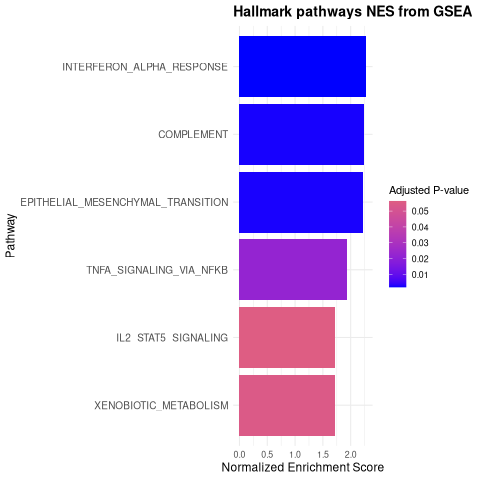

In [41]:
%%R

# Create the ggplot
plot <- ggplot(filtered_fgseaResSignificant, aes(reorder(pathway, NES), NES)) +
  geom_col(aes(fill = padj)) +
  coord_flip() +
  scale_fill_gradient(low = "#0000FF", high = "#de5d83", na.value = "black", name = "Adjusted P-value") +
  labs(x = "Pathway", y = "Normalized Enrichment Score",
       title = "Hallmark pathways NES from GSEA") +
  theme_minimal() +
  theme(
    axis.text.y = element_text(size = 10),
    axis.title = element_text(size = 12),
    plot.title = element_text(size = 14, face = "bold")
  )

# Save the plot as a high-resolution PNG file
ggsave("./figures/GSEA/MOL_AL_hallmark_pathways_NES_GSEA.png", plot = plot, dpi = 300, width = 10, height = 8)

print(plot)

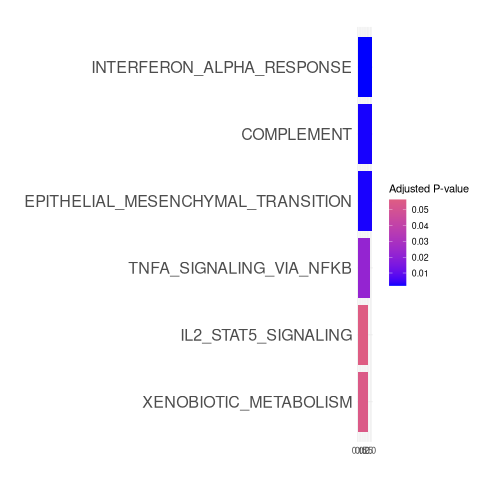

In [42]:
%%R

# Create the ggplot
plot <- ggplot(filtered_fgseaResSignificant, aes(reorder(pathway, NES), NES)) +
  geom_col(aes(fill = padj)) +
  coord_flip() +
  scale_fill_gradient(low = "#0000FF", high = "#de5d83", na.value = "black", name = "Adjusted P-value") +
  labs(x = "", y = "",
       title = "") +
  theme_minimal() +
  theme(
    axis.text.y = element_text(size = 16),
    axis.title = element_text(size = 16),
    plot.title = element_text(size = 16, face = "bold")
  )

# Save the plot as a high-resolution PNG file
ggsave("./figures/GSEA/MOL_AL_hallmark_pathways_NES_GSEA2.png", plot = plot, dpi = 300, width = 10, height = 8)

print(plot)

In [43]:
%%R

class(fgsea_MOL2_significant)

[1] "data.table" "data.frame"


In [44]:
%%R

fgsea_MOL2_significant <- as.data.frame(fgsea_MOL2_significant)

In [45]:
%%R
library(data.table)
fwrite(fgsea_MOL2_significant, file = "./files/filtered_fgseaResSignificant_AL_MOL_GvC.csv")

In [46]:
%%R
unique(fgsea_MOL2_significant$pathway)

[1] "HALLMARK_APOPTOSIS"                        
[2] "HALLMARK_COMPLEMENT"                       
[3] "HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION"
[4] "HALLMARK_IL2_STAT5_SIGNALING"              
[5] "HALLMARK_INFLAMMATORY_RESPONSE"            
[6] "HALLMARK_INTERFERON_ALPHA_RESPONSE"        
[7] "HALLMARK_INTERFERON_GAMMA_RESPONSE"        
[8] "HALLMARK_TNFA_SIGNALING_VIA_NFKB"          
[9] "HALLMARK_XENOBIOTIC_METABOLISM"            


In [47]:
%%R

# Define the pathway of interest
pathway_of_interest <- "HALLMARK_IL6_JAK_STAT3_SIGNALING"

# Subset the data to get the row with the specified pathway
selected_row <- fgsea_MOL2_significant[fgsea_MOL2_significant$pathway == pathway_of_interest, ]

# Extract the leadingEdge column as a list of gene symbols
leading_edge_genes <- unlist(selected_row$leadingEdge)

# Print the list of genes
print(leading_edge_genes)

NULL


In [48]:
%%R
# Filter genes_down_sorted for genes in leading_edge_genes
matching_genes <- genes_up_sorted[genes_up_sorted$gene %in% leading_edge_genes, ]

# Print the filtered data frame
print(matching_genes)

# Optionally, count the number of matching genes
num_matching_genes <- nrow(matching_genes)
cat("Number of matching genes found in genes_down_sorted:", num_matching_genes, "\n")

[1] gene      gene.1    logFC     AveExpr   t         P.Value   adj.P.Val
[8] B         logFC_rev
<0 rows> (or 0-length row.names)
Number of matching genes found in genes_down_sorted: 0 


In [49]:
%%R

# Define the pathway of interest
pathway_of_interest <- "HALLMARK_INTERFERON_ALPHA_RESPONSE"

# Subset the data to get the row with the specified pathway
selected_row <- fgsea_MOL2_significant[fgsea_MOL2_significant$pathway == pathway_of_interest, ]

# Extract the leadingEdge column as a list of gene symbols
leading_edge_genes <- unlist(selected_row$leadingEdge)

# Print the list of genes
print(leading_edge_genes)

 [1] "GBP2"   "ISG20"  "PARP14" "IRF1"   "RSAD2"  "PARP9"  "CSF1"   "SP110" 
 [9] "UBE2L6" "PARP12" "IRF7"   "TENT5A" "PSMB9" 


In [50]:
%%R
# Filter genes_down_sorted for genes in leading_edge_genes
matching_genes <- genes_up_sorted[genes_up_sorted$gene %in% leading_edge_genes, ]

# Print the filtered data frame
print(matching_genes)

# Optionally, count the number of matching genes
num_matching_genes <- nrow(matching_genes)
cat("Number of matching genes found in genes_down_sorted:", num_matching_genes, "\n")

      gene gene.1      logFC   AveExpr         t      P.Value    adj.P.Val
46    GBP2   GBP2 -6.1237731 2.5626584 -8.010834 1.288585e-08 2.880693e-06
149 PARP14 PARP14 -3.8068994 1.9331008 -6.257406 8.030583e-07 5.652129e-05
302  RSAD2  RSAD2 -3.4134772 0.5939815 -5.377317 1.095682e-05 3.795050e-04
570   IRF7   IRF7 -2.2082389 2.1052584 -4.607510 9.653937e-05 1.776155e-03
174   IRF1   IRF1 -1.9429213 2.7376744 -6.258329 1.387004e-06 8.319560e-05
311  PARP9  PARP9 -1.9259443 4.3895229 -5.369550 1.270342e-05 4.278071e-04
90   ISG20  ISG20 -1.8388068 4.6233640 -6.859319 1.764002e-07 2.055454e-05
703 TENT5A TENT5A -1.8279889 2.5105731 -4.471162 2.106878e-04 3.142935e-03
495 PARP12 PARP12 -1.4516637 3.6630526 -5.026576 5.730826e-05 1.214125e-03
429   CSF1   CSF1 -1.3520510 4.8222533 -4.920461 3.846969e-05 9.391518e-04
490 UBE2L6 UBE2L6 -1.3080227 2.1602267 -4.599569 5.625754e-05 1.203802e-03
780  PSMB9  PSMB9 -1.1397647 3.8271273 -4.210144 3.029515e-04 4.070090e-03
464  SP110  SP110 -0.8299

In [51]:
%%R

# Define the pathway of interest
pathway_of_interest <- "HALLMARK_INTERFERON_GAMMA_RESPONSE"

# Subset the data to get the row with the specified pathway
selected_row <- fgsea_MOL2_significant[fgsea_MOL2_significant$pathway == pathway_of_interest, ]

# Extract the leadingEdge column as a list of gene symbols
leading_edge_genes <- unlist(selected_row$leadingEdge)

# Print the list of genes
print(leading_edge_genes)

 [1] "ISG20"  "NLRC5"  "HLA-B"  "PARP14" "IRF1"   "RSAD2"  "CASP7"  "SP110" 
 [9] "UBE2L6" "PARP12" "APOL6"  "IRF7"   "RIPK1"  "NOD1"   "TAPBP"  "PSMB9" 
[17] "LATS2"  "IFIH1"  "STAT1"  "CDKN1A" "IFI44"  "HERC6"  "STAT3"  "GCH1"  
[25] "BTG1"   "MT2A"   "PML"    "TOR1B"  "PTPN6"  "MTHFD2"


In [52]:
%%R
# Filter genes_down_sorted for genes in leading_edge_genes
matching_genes <- genes_up_sorted[genes_up_sorted$gene %in% leading_edge_genes, ]

# Print the filtered data frame
print(matching_genes)

# Optionally, count the number of matching genes
num_matching_genes <- nrow(matching_genes)
cat("Number of matching genes found in genes_down_sorted:", num_matching_genes, "\n")

       gene gene.1      logFC   AveExpr         t      P.Value    adj.P.Val
142   HLA-B  HLA-B -4.3372806 2.8502434 -6.785372 7.319631e-07 5.405702e-05
149  PARP14 PARP14 -3.8068994 1.9331008 -6.257406 8.030583e-07 5.652129e-05
302   RSAD2  RSAD2 -3.4134772 0.5939815 -5.377317 1.095682e-05 3.795050e-04
390   CASP7  CASP7 -2.7608417 2.9211651 -5.212668 2.573166e-05 6.919177e-04
108   NLRC5  NLRC5 -2.6343112 3.9410402 -7.015664 3.157183e-07 3.065683e-05
1230 CDKN1A CDKN1A -2.5003267 1.5953939 -3.542983 1.540516e-03 1.313446e-02
570    IRF7   IRF7 -2.2082389 2.1052584 -4.607510 9.653937e-05 1.776155e-03
1273  IFI44  IFI44 -2.1982857 1.4547472 -3.495505 1.693270e-03 1.394919e-02
566   APOL6  APOL6 -1.9794297 2.3280302 -4.927985 9.299088e-05 1.722960e-03
174    IRF1   IRF1 -1.9429213 2.7376744 -6.258329 1.387004e-06 8.319560e-05
589    NOD1   NOD1 -1.9077697 2.0973889 -4.495900 1.101592e-04 1.961358e-03
90    ISG20  ISG20 -1.8388068 4.6233640 -6.859319 1.764002e-07 2.055454e-05
1926  PTPN6 

# CIL/RL_MOL

In [53]:
%%R

# Replace the file path with the actual path if the file is not in the current directory
df <- read.csv("./files/MOL_GvC_WM_v_RL_dream.csv")
head(df)  # Display the first few rows of the data frame to confirm it's loaded correctly

        gene      logFC  AveExpr         t      P.Value    adj.P.Val         B
1     FCHSD2  2.1578351 8.727854 17.221175 1.807438e-14 2.316774e-10 21.643558
2     KCNAB1  4.4666887 6.548477 12.991036 5.934711e-12 3.803556e-08 15.739906
3 AC022182.1  2.4251410 3.670108 11.280059 9.536502e-11 4.074630e-07 13.871828
4     PLPPR1  2.1458934 7.492648 11.587528 2.531274e-10 8.111468e-07  9.989267
5      MMP17  3.5191120 2.405612  8.706449 1.340425e-08 3.389688e-05  1.481296
6      SF3A1 -0.8336393 4.066929 -8.517618 1.681238e-08 3.389688e-05  9.685838
      z.std     gene.1
1  7.663634     FCHSD2
2  6.881208     KCNAB1
3  6.474122 AC022182.1
4  6.325064     PLPPR1
5  5.680830      MMP17
6 -5.641961      SF3A1


In [54]:
%%R

df <- df %>%
  mutate(logFC_rev = logFC * -1)

In [55]:
%%R
# Calculate the number of genes with adj.P.Val < 0.05 and |logFC| > 1
genes_up <- df[df$adj.P.Val < 0.05 & df$logFC_rev > 0.585, ]
num_genes_up <- nrow(genes_up)

# Print the number of significant genes
print(num_genes_up)

genes_up_sorted <- genes_up[order(genes_up$logFC_rev, decreasing = TRUE), ]

# View the head of the significant genes data frame
head(genes_up_sorted)

[1] 367
        gene     logFC   AveExpr         t      P.Value   adj.P.Val          B
277     EGR1 -5.313476 1.4426433 -4.527942 2.724879e-04 0.012609204 -0.7671184
368     GBP2 -4.931257 0.7175863 -4.250387 4.642876e-04 0.016171842 -2.0479198
56     HLA-B -4.565459 2.3549507 -7.328770 5.157742e-06 0.001180570  2.5091372
133 ARHGAP24 -4.458723 3.5360347 -5.889187 3.501024e-05 0.003374145  1.8933829
228    ANXA2 -4.406114 0.4269273 -4.748119 1.386904e-04 0.007797075 -1.8869533
165   GPRC5A -4.166927 0.7947762 -5.062537 6.465058e-05 0.005022371  0.9011153
        z.std   gene.1 logFC_rev
277 -3.640142     EGR1  5.313476
368 -3.500557     GBP2  4.931257
56  -4.558267    HLA-B  4.565459
133 -4.138160 ARHGAP24  4.458723
228 -3.810492    ANXA2  4.406114
165 -3.995160   GPRC5A  4.166927


In [56]:
%%R
# Calculate the number of genes with adj.P.Val < 0.05 and |logFC| > 1
genes_down <- df[df$adj.P.Val < 0.05 & df$logFC_rev < -0.585, ]
num_genes_down <- nrow(genes_down)

# Print the number of significant genes
print(num_genes_down)

genes_down_sorted <- genes_down[order(genes_down$logFC_rev, decreasing = FALSE), ]

# View the head of the significant genes data frame
head(genes_down_sorted)

[1] 365
      gene    logFC  AveExpr         t      P.Value    adj.P.Val          B
523  DPP10 4.704838 2.609465  3.739296 1.103533e-03 2.704605e-02 -2.2998257
150 ATP8A2 4.660569 5.176498  5.013160 4.762359e-05 4.062542e-03  2.0998200
158   GRM7 4.553017 3.231313  4.968429 5.314953e-05 4.311839e-03  1.9629857
2   KCNAB1 4.466689 6.548477 12.991036 5.934711e-12 3.803556e-08 15.7399058
274 ARPP21 4.432575 2.886587  4.334422 2.618493e-04 1.223993e-02 -0.6204954
179  PCDH7 3.992072 3.312041  4.818293 7.733640e-05 5.537977e-03 -0.9503429
       z.std gene.1 logFC_rev
523 3.262708  DPP10 -4.704838
150 4.066993 ATP8A2 -4.660569
158 4.041327   GRM7 -4.553017
2   6.881208 KCNAB1 -4.466689
274 3.650383 ARPP21 -4.432575
179 3.952508  PCDH7 -3.992072


In [57]:
%%R

dim(df)

[1] 12818    10


In [58]:
%%R

my_genes <- df$gene
head(my_genes)

[1] "FCHSD2"     "KCNAB1"     "AC022182.1" "PLPPR1"     "MMP17"     
[6] "SF3A1"     


In [59]:
%%R
# Check column names in the dataframe
colnames(df)

 [1] "gene"      "logFC"     "AveExpr"   "t"         "P.Value"   "adj.P.Val"
 [7] "B"         "z.std"     "gene.1"    "logFC_rev"


In [60]:
%%R

# Filter the dataset for significant genes
filtered_df <- df[abs(df$logFC_rev) >= 0.585 & df$adj.P.Val < 0.05, ]

# Compute ranking score: sign(logFC) * -log10(P.Value)
filtered_df$ranking_score <- sign(filtered_df$logFC_rev) * -log10(filtered_df$P.Value)

# Assign names to the rankings
rankings <- filtered_df$ranking_score
names(rankings) <- filtered_df$gene

# Sort the rankings in descending order
rankings <- sort(rankings, decreasing = TRUE)

In [61]:
%%R

# Ensure the length of the gene column matches the length of rankings
length(df$gene) == length(rankings)

[1] FALSE


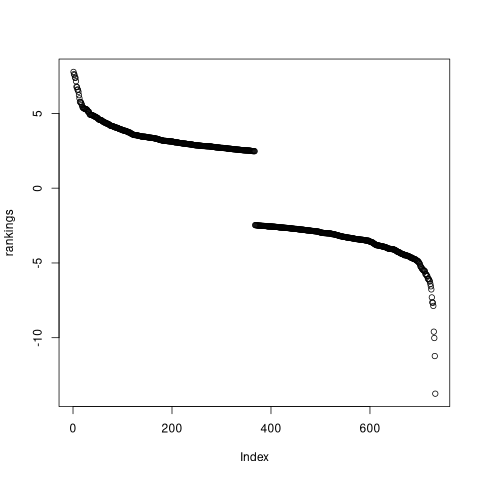

In [62]:
%%R

plot(rankings)

In [63]:
%%R

max(rankings)

[1] 7.774371


In [64]:
%%R

min(rankings)

[1] -13.74294


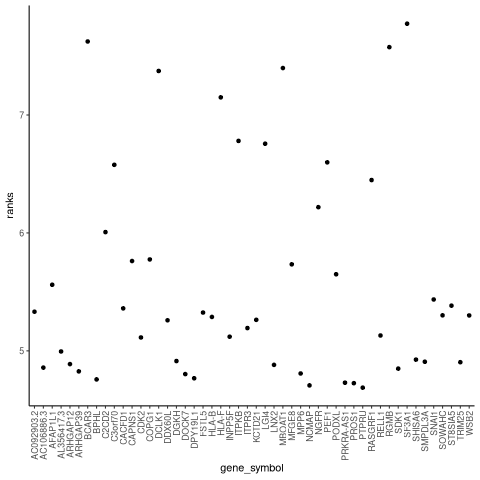

In [65]:
%%R

ggplot(data.frame(gene_symbol = names(rankings)[1:50], ranks = rankings[1:50]), aes(gene_symbol, ranks)) + 
    geom_point() +
    theme_classic() + 
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

## set up gene lists

In [66]:
%%R
fgsea_res <- fgsea(pathways = pathwaysH, 
                  stats    = rankings,
                  scoreType = 'std',
                  minSize  = 15,
                  maxSize  = 500)

In [67]:
%%R
fgsea_res

                              pathway       pval       padj   log2err        ES
                               <char>      <num>      <num>     <num>     <num>
1:       HALLMARK_IL2_STAT5_SIGNALING 0.11498973 0.11498973 0.1882041 0.3222599
2: HALLMARK_INTERFERON_GAMMA_RESPONSE 0.01427437 0.02854874 0.3807304 0.4326900
        NES  size                                 leadingEdge
      <num> <int>                                      <list>
1: 1.396086    17 SMPDL3A,CSF1,TNFRSF21,SCN9A,ADAM19,MAFF,...
2: 1.843897    16     HLA-B,TRIM25,IRF1,HLA-A,NLRC5,PSMB9,...


In [68]:
%%R

dim(fgsea_res)

[1] 2 8


In [69]:
%%R
library(data.table)

fwrite(fgsea_res, file = "./files/fgsea_RL_GvC_all.csv")

In [70]:
%%R

# Filter for significant results with padj < 0.05
fgsea_MOL4_significant <- fgsea_res %>% filter(padj < 0.1)
dim(fgsea_MOL4_significant)

[1] 1 8


In [71]:
%%R

head(fgsea_MOL4_significant)

                              pathway       pval       padj   log2err      ES
                               <char>      <num>      <num>     <num>   <num>
1: HALLMARK_INTERFERON_GAMMA_RESPONSE 0.01427437 0.02854874 0.3807304 0.43269
        NES  size                             leadingEdge
      <num> <int>                                  <list>
1: 1.843897    16 HLA-B,TRIM25,IRF1,HLA-A,NLRC5,PSMB9,...


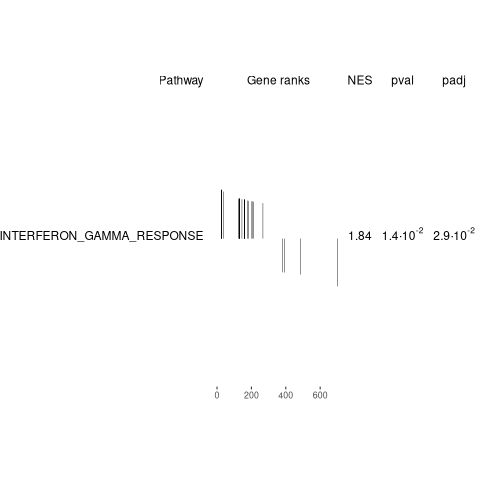

In [72]:
%%R

plotGseaTable(pathwaysH[fgsea_MOL4_significant$pathway], 
              rankings, 
              fgsea_MOL4_significant, 
              gseaParam = 0.5)

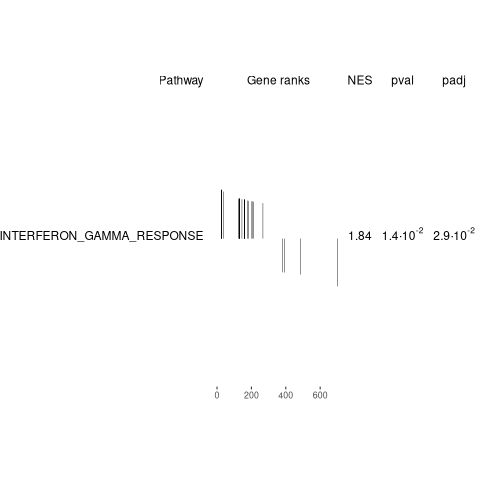

In [73]:
%%R

topUp <- fgsea_MOL4_significant %>% 
    filter(ES > 0) %>% 
    top_n(10, wt=-padj)

topDown <- fgsea_MOL4_significant %>% 
    filter(ES < 0) %>% 
    top_n(10, wt=-padj)

topPathways <- bind_rows(topUp, topDown) %>% 
    arrange(-ES)

plotGseaTable(pathwaysH[topPathways$pathway], 
              rankings, 
              fgsea_MOL4_significant, 
              gseaParam = 0.5)

In [74]:
%%R

collapsedPathways <- collapsePathways(fgsea_MOL4_significant[order(pval)][padj < 0.1], 
                                      pathwaysH, rankings)

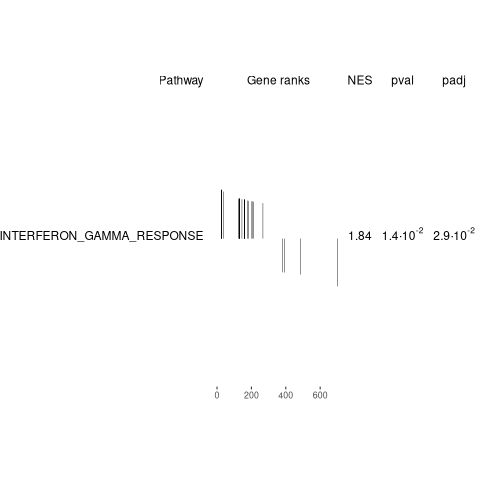

In [75]:
%%R

mainPathways <- fgsea_MOL4_significant[pathway %in% collapsedPathways$mainPathways][
                         order(-NES), pathway]
plotGseaTable(pathwaysH[mainPathways], rankings, fgsea_MOL4_significant, 
              gseaParam = 0.5)

In [76]:
%%R

fgseaResTidy <- fgsea_res %>%
  as_tibble() %>%
  arrange(desc(NES))

In [77]:
%%R

# Subset significant results
fgseaResSignificant <- fgseaResTidy[fgseaResTidy$padj < 0.1, ]

# Select columns to display and sort by padj
fgseaResSignificant <- fgseaResSignificant[, c("pathway", "padj", "NES", "size")]
fgseaResSignificant <- fgseaResSignificant[order(fgseaResSignificant$padj), ]

# Print the table
head(fgseaResSignificant)

# A tibble: 1 × 4
  pathway                              padj   NES  size
  <chr>                               <dbl> <dbl> <int>
1 HALLMARK_INTERFERON_GAMMA_RESPONSE 0.0285  1.84    16


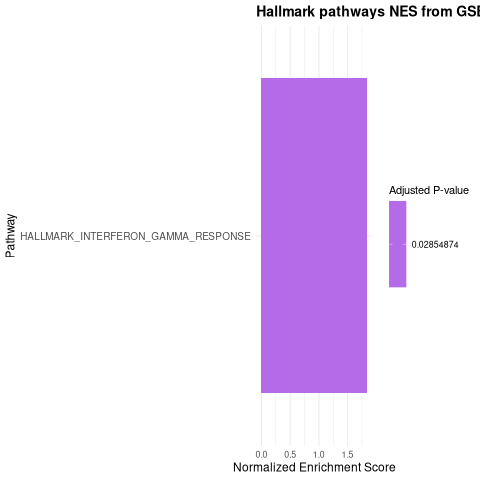

In [78]:
%%R

# Create the ggplot with a color scale for padj
ggplot(fgseaResSignificant, aes(reorder(pathway, NES), NES)) +
  geom_col(aes(fill = padj)) +
  coord_flip() +
  scale_fill_gradient(low = "blue", high = "pink", na.value = "black", name = "Adjusted P-value") +
  labs(x = "Pathway", y = "Normalized Enrichment Score",
       title = "Hallmark pathways NES from GSEA") +
  theme_minimal() +
  theme(
    axis.text.y = element_text(size = 10),
    axis.title = element_text(size = 12),
    plot.title = element_text(size = 14, face = "bold")
  )

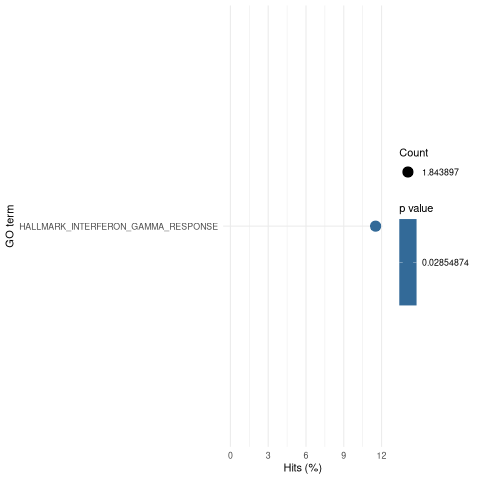

In [79]:
%%R

# Calculate hits percentage (if 'numDEInCat' and 'numInCat' equivalent are 'NES' and 'size')
fgseaResSignificant <- fgseaResSignificant %>%
  mutate(hitsPerc = NES * 100 / size)

# Ensure the columns 'padj' and 'NES' are present for the plot
fgseaResSignificant <- fgseaResSignificant %>%
  rename(term = pathway, over_represented_pvalue = padj, numDEInCat = NES)

# Create the plot
ggplot(fgseaResSignificant, aes(x = hitsPerc, y = term, colour = over_represented_pvalue, size = numDEInCat)) +
  geom_point() +
  expand_limits(x = 0) +
  labs(x = "Hits (%)", y = "GO term", colour = "p value", size = "Count") +
  theme_minimal()

#https://bioinformatics-core-shared-training.github.io/cruk-summer-school-2018/RNASeq2018/html/06_Gene_set_testing.nb.html

In [80]:
%%R

# Subset significant results
fgseaResSignificant <- fgseaResTidy[fgseaResTidy$padj < 0.1, ]

# Select columns to display and sort by padj
fgseaResSignificant <- fgseaResSignificant[, c("pathway", "padj", "NES", "size")]
fgseaResSignificant <- fgseaResSignificant[order(fgseaResSignificant$padj), ]

# Print the table
head(fgseaResSignificant)

# A tibble: 1 × 4
  pathway                              padj   NES  size
  <chr>                               <dbl> <dbl> <int>
1 HALLMARK_INTERFERON_GAMMA_RESPONSE 0.0285  1.84    16


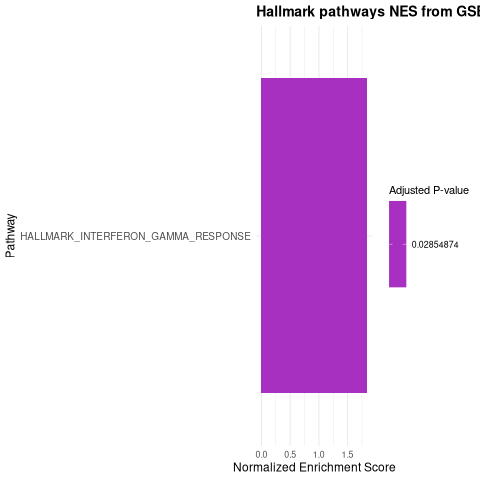

In [81]:
%%R

# Filter fgseaResSignificant to include only the main pathways from collapsedPathways
filtered_fgseaResSignificant <- fgseaResSignificant %>%
  filter(pathway %in% collapsedPathways$mainPathways)

# Create the ggplot with a color scale for padj
ggplot(filtered_fgseaResSignificant, aes(reorder(pathway, NES), NES)) +
  geom_col(aes(fill = padj)) +
  coord_flip() +
  scale_fill_gradient(low = "#0000FF", high = "#de5d83", na.value = "black", name = "Adjusted P-value") +
  labs(x = "Pathway", y = "Normalized Enrichment Score",
       title = "Hallmark pathways NES from GSEA") +
  theme_minimal() +
  theme(
    axis.text.y = element_text(size = 10),
    axis.title = element_text(size = 12),
    plot.title = element_text(size = 14, face = "bold")
  )


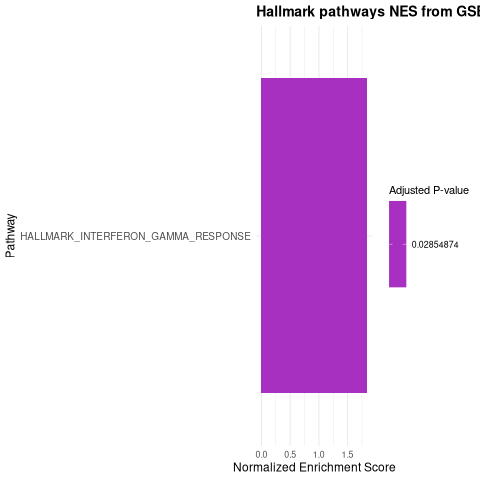

In [82]:
%%R

# Create the ggplot
plot <- # Create the ggplot with a color scale for padj
ggplot(filtered_fgseaResSignificant, aes(reorder(pathway, NES), NES)) +
  geom_col(aes(fill = padj)) +
  coord_flip() +
  scale_fill_gradient(low = "#0000FF", high = "#de5d83", na.value = "black", name = "Adjusted P-value") +
  labs(x = "Pathway", y = "Normalized Enrichment Score",
       title = "Hallmark pathways NES from GSEA") +
  theme_minimal() +
  theme(
    axis.text.y = element_text(size = 10),
    axis.title = element_text(size = 12),
    plot.title = element_text(size = 14, face = "bold")
  )

# Save the plot as a high-resolution PNG file
ggsave("./figures/GSEA/MOL_RL_reduced_hallmark_pathways_NES_GSEA.png", plot = plot, dpi = 300, width = 10, height = 8)

print(plot)

In [83]:
%%R

# Remove "HALLMARK_" prefix from the 'pathway' column
filtered_fgseaResSignificant$pathway <- gsub("^HALLMARK_", "", filtered_fgseaResSignificant$pathway)

# View the updated heatmap_df
head(filtered_fgseaResSignificant)

# A tibble: 1 × 4
  pathway                     padj   NES  size
  <chr>                      <dbl> <dbl> <int>
1 INTERFERON_GAMMA_RESPONSE 0.0285  1.84    16


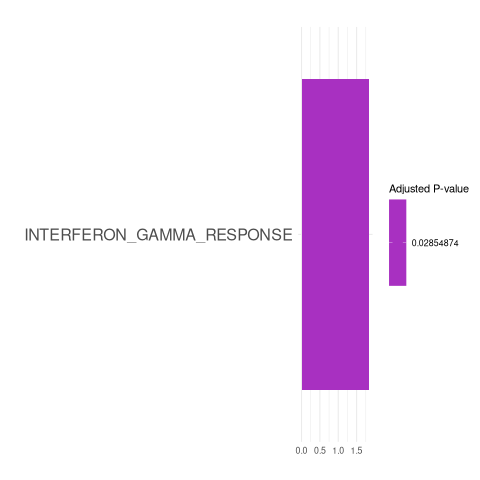

In [84]:
%%R

# Create the ggplot
plot <- ggplot(filtered_fgseaResSignificant, aes(reorder(pathway, NES), NES)) +
  geom_col(aes(fill = padj)) +
  coord_flip() +
  scale_fill_gradient(low = "#0000FF", high = "#de5d83", na.value = "black", name = "Adjusted P-value") +
  labs(x = "", y = "",
       title = "") +
  theme_minimal() +
  theme(
    axis.text.y = element_text(size = 16),
    axis.title = element_text(size = 16),
    plot.title = element_text(size = 16, face = "bold")
  )

# Save the plot as a high-resolution PNG file
ggsave("./figures/GSEA/MOL_RL_reduced_hallmark_pathways_NES_GSEA2.png", plot = plot, dpi = 300, width = 10, height = 8)

print(plot)

In [85]:
%%R

class(fgsea_MOL4_significant)

[1] "data.table" "data.frame"


In [86]:
%%R

fgsea_MOL4_significant <- as.data.frame(fgsea_MOL4_significant)

In [87]:
%%R
library(data.table)
fwrite(fgsea_MOL4_significant, file = "./files/filtered_fgseaResSignificant_RL_MOL_GvC.csv")

In [88]:
%%R
unique(fgsea_MOL4_significant$pathway)

[1] "HALLMARK_INTERFERON_GAMMA_RESPONSE"


In [90]:
%%R

# Define the pathway of interest
pathway_of_interest <- "HALLMARK_INTERFERON_GAMMA_RESPONSE"

# Subset the data to get the row with the specified pathway
selected_row <- fgsea_MOL4_significant[fgsea_MOL4_significant$pathway == pathway_of_interest, ]

# Extract the leadingEdge column as a list of gene symbols
leading_edge_genes <- unlist(selected_row$leadingEdge)

# Print the list of genes
print(leading_edge_genes)

 [1] "HLA-B"  "TRIM25" "IRF1"   "HLA-A"  "NLRC5"  "PSMB9"  "HERC6"  "NOD1"  
 [9] "ISG20"  "PML"    "IFIH1" 


In [91]:
%%R
# Filter genes_down_sorted for genes in leading_edge_genes
matching_genes <- genes_up_sorted[genes_up_sorted$gene %in% leading_edge_genes, ]

# Print the filtered data frame
print(matching_genes)

# Optionally, count the number of matching genes
num_matching_genes <- nrow(matching_genes)
cat("Number of matching genes found in genes_down_sorted:", num_matching_genes, "\n")

      gene      logFC  AveExpr         t      P.Value   adj.P.Val          B
56   HLA-B -4.5654595 2.354951 -7.328770 5.157742e-06 0.001180570  2.5091372
285  HLA-A -1.9483925 5.160799 -4.500450 2.912968e-04 0.013101200 -1.5548179
458  ISG20 -1.8968175 4.209833 -3.961998 8.032841e-04 0.022481431 -1.6069645
324  NLRC5 -1.8411442 3.093646 -4.302752 3.652145e-04 0.014437771 -1.9329525
76  TRIM25 -1.8270803 1.473249 -5.563286 1.248337e-05 0.002105418  3.2676113
280   IRF1 -1.7746431 2.345040 -4.487822 2.816067e-04 0.012866553 -1.4205324
429   NOD1 -1.7528494 1.549460 -4.787213 6.773772e-04 0.020239209  0.6404712
355  PSMB9 -1.3629336 3.738769 -4.617123 4.333407e-04 0.015643093 -0.2496337
480  IFIH1 -1.2676731 2.573128 -4.594468 9.171567e-04 0.024491907  0.8495818
406  HERC6 -1.0841539 3.401247 -4.456486 6.045711e-04 0.019044074 -0.0142576
461    PML -0.8259102 3.149903 -5.207736 8.201197e-04 0.022803241  2.3689846
        z.std gene.1 logFC_rev
56  -4.558267  HLA-B 4.5654595
285 -3.622919 

In [127]:
%%R

# Define the pathway of interest
pathway_of_interest <- "HALLMARK_INTERFERON_ALPHA_RESPONSE"

# Subset the data to get the row with the specified pathway
selected_row <- fgsea_MOL4_significant[fgsea_MOL4_significant$pathway == pathway_of_interest, ]

# Extract the leadingEdge column as a list of gene symbols
leading_edge_genes <- unlist(selected_row$leadingEdge)

# Print the list of genes
print(leading_edge_genes)

NULL


In [128]:
%%R
# Filter genes_down_sorted for genes in leading_edge_genes
matching_genes <- genes_up_sorted[genes_up_sorted$gene %in% leading_edge_genes, ]

# Print the filtered data frame
print(matching_genes)

# Optionally, count the number of matching genes
num_matching_genes <- nrow(matching_genes)
cat("Number of matching genes found in genes_down_sorted:", num_matching_genes, "\n")

 [1] gene      logFC     AveExpr   t         P.Value   adj.P.Val B        
 [8] z.std     gene.1    logFC_rev
<0 rows> (or 0-length row.names)
Number of matching genes found in genes_down_sorted: 0 


In [129]:
%%R

# Define the pathway of interest
pathway_of_interest <- "HALLMARK_CHOLESTEROL_HOMEOSTASIS"

# Subset the data to get the row with the specified pathway
selected_row <- fgsea_MOL4_significant[fgsea_MOL4_significant$pathway == pathway_of_interest, ]

# Extract the leadingEdge column as a list of gene symbols
leading_edge_genes <- unlist(selected_row$leadingEdge)

# Print the list of genes
print(leading_edge_genes)

NULL


In [130]:
%%R
# Filter genes_down_sorted for genes in leading_edge_genes
matching_genes <- genes_up_sorted[genes_up_sorted$gene %in% leading_edge_genes, ]

# Print the filtered data frame
print(matching_genes)

# Optionally, count the number of matching genes
num_matching_genes <- nrow(matching_genes)
cat("Number of matching genes found in genes_down_sorted:", num_matching_genes, "\n")

 [1] gene      logFC     AveExpr   t         P.Value   adj.P.Val B        
 [8] z.std     gene.1    logFC_rev
<0 rows> (or 0-length row.names)
Number of matching genes found in genes_down_sorted: 0 


# CREATE A COMBINED HEATMAP-- NEW NES colored

In [131]:
%%R

# Load the data.table package
library(data.table)

# Read the files back into R
LPC_de <- fread("./files/filtered_fgseaResSignificant_AL_MOL_GvC.csv")
LPC_re <- fread("./files/filtered_fgseaResSignificant_RL_MOL_GvC.csv")

In [132]:
%%R
print(dim(LPC_de))
print(dim(LPC_re))

[1] 9 8
[1] 1 8


In [133]:
%%R
# For detailed differences in column names (if any)
list_columns <- list(
  LPC_de = colnames(LPC_de),
  LPC_re = colnames(LPC_re)
)

print(list_columns)

$LPC_de
[1] "pathway"     "pval"        "padj"        "log2err"     "ES"         
[6] "NES"         "size"        "leadingEdge"

$LPC_re
[1] "pathway"     "pval"        "padj"        "log2err"     "ES"         
[6] "NES"         "size"        "leadingEdge"



In [134]:
%%R

# Subset the data frames to include only pathway, padj, NES, and size
subset_columns <- c("pathway", "NES", "padj")

LPC_de_subset <- LPC_de[, ..subset_columns]
LPC_re_subset <- LPC_re[, ..subset_columns]

In [135]:
%%R

# Combine the 'pathway' columns from all the data frames
all_pathways <- unique(c(LPC_de$pathway, LPC_re$pathway))

# Verify the unique pathways
print(head(all_pathways))

# Check the total number of unique pathways
length(all_pathways)

[1] "HALLMARK_APOPTOSIS"                        
[2] "HALLMARK_COMPLEMENT"                       
[3] "HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION"
[4] "HALLMARK_IL2_STAT5_SIGNALING"              
[5] "HALLMARK_INFLAMMATORY_RESPONSE"            
[6] "HALLMARK_INTERFERON_ALPHA_RESPONSE"        
[1] 9


In [136]:
%%R
# Function to ensure each data frame includes all pathways and fills missing ones with NaN
fill_missing_pathways <- function(df, all_pathways) {
  # Identify pathways that are missing in the current data frame
  missing_pathways <- setdiff(all_pathways, df$pathway)
  
  # Create a data frame with missing pathways, NES and padj set to NaN
  missing_data <- data.frame(pathway = missing_pathways, 
                             NES = rep(NaN, length(missing_pathways)), 
                             padj = rep(NaN, length(missing_pathways)))
  
  # Combine the original data frame with the missing pathways
  df <- rbind(df[, c("pathway", "NES", "padj")], missing_data)
  
  # Sort by pathway to maintain a consistent order
  df <- df[order(df$pathway), ]
  
  return(df)
}

# List of all unique pathways
all_pathways <- unique(c(LPC_de$pathway, LPC_re$pathway))

# Apply the function to all data frames
LPC_de_filtered <- fill_missing_pathways(LPC_de_subset, all_pathways)
LPC_re_filtered <- fill_missing_pathways(LPC_re_subset, all_pathways)

In [137]:
%%R

LPC_de_filtered$condition <- "AL_MOL_G"
LPC_re_filtered$condition <- "RL_MOL_G"

# Combine all datasets into a single dataframe
combined_df <- rbind(LPC_de_filtered, LPC_re_filtered)

# Verify the structure
head(combined_df)

                                      pathway      NES        padj condition
                                       <char>    <num>       <num>    <char>
1:                         HALLMARK_APOPTOSIS 1.897157 0.022373336  AL_MOL_G
2:                        HALLMARK_COMPLEMENT 2.234759 0.002560728  AL_MOL_G
3: HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION 2.223225 0.002609011  AL_MOL_G
4:               HALLMARK_IL2_STAT5_SIGNALING 1.718310 0.056299729  AL_MOL_G
5:             HALLMARK_INFLAMMATORY_RESPONSE 1.614002 0.099175931  AL_MOL_G
6:         HALLMARK_INTERFERON_ALPHA_RESPONSE 2.280342 0.002002414  AL_MOL_G


In [138]:
%%R
dim(combined_df)

[1] 18  4


In [139]:
%%R

# Remove "HALLMARK_" prefix from the 'pathway' column
combined_df$pathway <- gsub("^HALLMARK_", "", combined_df$pathway)

# View the updated heatmap_df
head(combined_df)

                             pathway      NES        padj condition
                              <char>    <num>       <num>    <char>
1:                         APOPTOSIS 1.897157 0.022373336  AL_MOL_G
2:                        COMPLEMENT 2.234759 0.002560728  AL_MOL_G
3: EPITHELIAL_MESENCHYMAL_TRANSITION 2.223225 0.002609011  AL_MOL_G
4:               IL2_STAT5_SIGNALING 1.718310 0.056299729  AL_MOL_G
5:             INFLAMMATORY_RESPONSE 1.614002 0.099175931  AL_MOL_G
6:         INTERFERON_ALPHA_RESPONSE 2.280342 0.002002414  AL_MOL_G


In [140]:
%%R
head(combined_df)

                             pathway      NES        padj condition
                              <char>    <num>       <num>    <char>
1:                         APOPTOSIS 1.897157 0.022373336  AL_MOL_G
2:                        COMPLEMENT 2.234759 0.002560728  AL_MOL_G
3: EPITHELIAL_MESENCHYMAL_TRANSITION 2.223225 0.002609011  AL_MOL_G
4:               IL2_STAT5_SIGNALING 1.718310 0.056299729  AL_MOL_G
5:             INFLAMMATORY_RESPONSE 1.614002 0.099175931  AL_MOL_G
6:         INTERFERON_ALPHA_RESPONSE 2.280342 0.002002414  AL_MOL_G


In [141]:
%%R
tail(combined_df)

                     pathway      NES       padj condition
                      <char>    <num>      <num>    <char>
1:       IL2_STAT5_SIGNALING      NaN        NaN  RL_MOL_G
2:     INFLAMMATORY_RESPONSE      NaN        NaN  RL_MOL_G
3: INTERFERON_ALPHA_RESPONSE      NaN        NaN  RL_MOL_G
4: INTERFERON_GAMMA_RESPONSE 1.799277 0.03208174  RL_MOL_G
5:   TNFA_SIGNALING_VIA_NFKB      NaN        NaN  RL_MOL_G
6:     XENOBIOTIC_METABOLISM      NaN        NaN  RL_MOL_G


In [142]:
%%R

# Transform padj to -log10 for better visualization
combined_df$log_padj <- -log10(combined_df$padj)

In [143]:
%%R

dim(combined_df)

[1] 18  5


In [144]:
%%R

head(combined_df, 20)

                              pathway      NES        padj condition log_padj
                               <char>    <num>       <num>    <char>    <num>
 1:                         APOPTOSIS 1.897157 0.022373336  AL_MOL_G 1.650269
 2:                        COMPLEMENT 2.234759 0.002560728  AL_MOL_G 2.591637
 3: EPITHELIAL_MESENCHYMAL_TRANSITION 2.223225 0.002609011  AL_MOL_G 2.583524
 4:               IL2_STAT5_SIGNALING 1.718310 0.056299729  AL_MOL_G 1.249494
 5:             INFLAMMATORY_RESPONSE 1.614002 0.099175931  AL_MOL_G 1.003594
 6:         INTERFERON_ALPHA_RESPONSE 2.280342 0.002002414  AL_MOL_G 2.698446
 7:         INTERFERON_GAMMA_RESPONSE 1.900071 0.025356235  AL_MOL_G 1.595915
 8:           TNFA_SIGNALING_VIA_NFKB 1.925632 0.022296172  AL_MOL_G 1.651770
 9:             XENOBIOTIC_METABOLISM 1.710075 0.054539554  AL_MOL_G 1.263288
10:                         APOPTOSIS      NaN         NaN  RL_MOL_G      NaN
11:                        COMPLEMENT      NaN         NaN  RL_M

In addition: Warning message:
Removed 8 rows containing missing values or values outside the scale range
(`geom_point()`). 


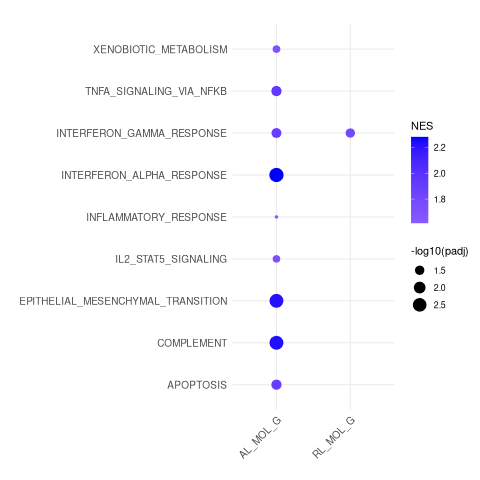

In [145]:
%%R

library(ggplot2)

# Set the factor levels for conditions to control the order
combined_df$condition <- factor(combined_df$condition, 
                                 levels = c("AL_MOL_G", "RL_MOL_G"))

# Create the dotplot with switched axes and assign to heatmap_plot
heatmap_plot <- ggplot(combined_df, aes(y = pathway, x = condition, size = log_padj, color = NES)) +
  geom_point() +
  scale_color_gradient2(low = "#c32148", mid = "white", high = "#0000FF", midpoint = 0) +
  theme_minimal() +
  theme(axis.text.y = element_text(size = 10), # Adjust pathway text size for readability
        axis.text.x = element_text(angle = 45, hjust = 1, size = 10)) + # Adjust condition text
  labs(x = "", y = "", 
       size = "-log10(padj)", color = "NES", 
       title = "")

# Show the plot
print(heatmap_plot)

In [146]:
%%R

# Remove rows with missing or NaN values in `log_padj` or `NES`
filtered_df <- combined_df[!is.na(combined_df$log_padj) & !is.na(combined_df$NES), ]
head(filtered_df)

                             pathway      NES        padj condition log_padj
                              <char>    <num>       <num>    <fctr>    <num>
1:                         APOPTOSIS 1.897157 0.022373336  AL_MOL_G 1.650269
2:                        COMPLEMENT 2.234759 0.002560728  AL_MOL_G 2.591637
3: EPITHELIAL_MESENCHYMAL_TRANSITION 2.223225 0.002609011  AL_MOL_G 2.583524
4:               IL2_STAT5_SIGNALING 1.718310 0.056299729  AL_MOL_G 1.249494
5:             INFLAMMATORY_RESPONSE 1.614002 0.099175931  AL_MOL_G 1.003594
6:         INTERFERON_ALPHA_RESPONSE 2.280342 0.002002414  AL_MOL_G 2.698446


In [147]:
%%R
dim(filtered_df)

[1] 10  5


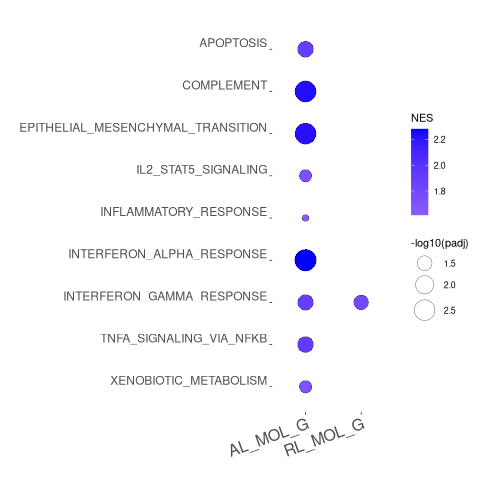

In [148]:
%%R

# Create the dotplot with adjustments
heatmap_plot <- ggplot(filtered_df, aes(y = pathway, x = condition, size = log_padj, fill = NES)) +
  geom_point(shape = 21, stroke = 0.2, color = "black") + # Add thin black outline to dots
  scale_fill_gradient2(low = "#c32148", mid = "white", high = "#0000FF", midpoint = 0) +
  scale_size_continuous(range = c(3, 10)) + # Increase size of dots (min=3, max=10)
  scale_y_discrete(limits = rev(levels(factor(filtered_df$pathway))),  # Reverse the y-axis order if needed
                   labels = function(x) paste0(x, "\n")) + # Add line breaks for extra vertical space
  theme_minimal() +
  theme(
    panel.grid = element_blank(), # Remove grid lines
    axis.text.y = element_text(size = 12), # Add vertical spacing for y-axis text
    axis.text.x = element_text(angle = 20, hjust = 1, size = 16, vjust = 1), # Adjust x-axis text spacing
    axis.ticks = element_line(linewidth = 0.3) # Adjust x-axis ticks with `linewidth`
  ) +
  labs(
    x = "", 
    y = "", 
    size = "-log10(padj)", 
    fill = "NES", 
    title = ""
  )

# Display the plot
print(heatmap_plot)

In [149]:
%%R
print(unique(filtered_df$pathway))

[1] "APOPTOSIS"                         "COMPLEMENT"                       
[3] "EPITHELIAL_MESENCHYMAL_TRANSITION" "IL2_STAT5_SIGNALING"              
[5] "INFLAMMATORY_RESPONSE"             "INTERFERON_ALPHA_RESPONSE"        
[7] "INTERFERON_GAMMA_RESPONSE"         "TNFA_SIGNALING_VIA_NFKB"          
[9] "XENOBIOTIC_METABOLISM"            


In [151]:
%%R

# Define the desired order for the pathways
desired_pathway_order <- c(
        "INTERFERON_GAMMA_RESPONSE",
        "INTERFERON_ALPHA_RESPONSE",
        "EPITHELIAL_MESENCHYMAL_TRANSITION",
        "COMPLEMENT",
        "TNFA_SIGNALING_VIA_NFKB",
        "APOPTOSIS",
        "XENOBIOTIC_METABOLISM",
        "IL2_STAT5_SIGNALING",
        "INFLAMMATORY_RESPONSE"
)

# Reorder the 'pathway' column in filtered_df
filtered_df$pathway <- factor(filtered_df$pathway, levels = desired_pathway_order)

# Verify the order
print(levels(filtered_df$pathway))

[1] "INTERFERON_GAMMA_RESPONSE"         "INTERFERON_ALPHA_RESPONSE"        
[3] "EPITHELIAL_MESENCHYMAL_TRANSITION" "COMPLEMENT"                       
[5] "TNFA_SIGNALING_VIA_NFKB"           "APOPTOSIS"                        
[7] "XENOBIOTIC_METABOLISM"             "IL2_STAT5_SIGNALING"              
[9] "INFLAMMATORY_RESPONSE"            


In [152]:
%%R
# Reverse the desired pathway order
reversed_pathway_order <- rev(desired_pathway_order)

# Reorder the 'pathway' column in filtered_df
filtered_df$pathway <- factor(filtered_df$pathway, levels = reversed_pathway_order)

# Verify the reversed order
print(levels(filtered_df$pathway))

[1] "INFLAMMATORY_RESPONSE"             "IL2_STAT5_SIGNALING"              
[3] "XENOBIOTIC_METABOLISM"             "APOPTOSIS"                        
[5] "TNFA_SIGNALING_VIA_NFKB"           "COMPLEMENT"                       
[7] "EPITHELIAL_MESENCHYMAL_TRANSITION" "INTERFERON_ALPHA_RESPONSE"        
[9] "INTERFERON_GAMMA_RESPONSE"        


In [153]:
%%R
# Dictionary to format pathway names
pathway_name_format <- list(
    "TNFA_SIGNALING_VIA_NFKB" = "TNFα Signaling via NF-κB",
    "INTERFERON_GAMMA_RESPONSE" = "Interferon-γ Response",
    "INTERFERON_ALPHA_RESPONSE" = "Interferon-α Response",
    "APOPTOSIS" = "Apoptosis",
    "IL2_STAT5_SIGNALING" = "IL-2/STAT5 Signaling",
    "INFLAMMATORY_RESPONSE" = "Inflammatory Response",
    "COMPLEMENT" = "Complement",
    "EPITHELIAL_MESENCHYMAL_TRANSITION" = "Epithelial-Mesenchymal Transition",
    "XENOBIOTIC_METABOLISM" = "Xenobiotic Metabolism"
)

# Example usage: format pathway names in a vector
formatted_pathways <- sapply(desired_pathway_order, function(x) pathway_name_format[[x]])

# Print formatted names
print(formatted_pathways)

          INTERFERON_GAMMA_RESPONSE           INTERFERON_ALPHA_RESPONSE 
            "Interferon-γ Response"             "Interferon-α Response" 
  EPITHELIAL_MESENCHYMAL_TRANSITION                          COMPLEMENT 
"Epithelial-Mesenchymal Transition"                        "Complement" 
            TNFA_SIGNALING_VIA_NFKB                           APOPTOSIS 
         "TNFα Signaling via NF-κB"                         "Apoptosis" 
              XENOBIOTIC_METABOLISM                 IL2_STAT5_SIGNALING 
            "Xenobiotic Metabolism"              "IL-2/STAT5 Signaling" 
              INFLAMMATORY_RESPONSE 
            "Inflammatory Response" 


In [154]:
%%R

# Define formatted pathway names dictionary
pathway_name_format <- c(
    "TNFA_SIGNALING_VIA_NFKB" = "TNFα Signaling via NF-κB",
    "INTERFERON_GAMMA_RESPONSE" = "Interferon-γ Response",
    "INTERFERON_ALPHA_RESPONSE" = "Interferon-α Response",
    "APOPTOSIS" = "Apoptosis",
    "IL2_STAT5_SIGNALING" = "IL-2/STAT5 Signaling",
    "INFLAMMATORY_RESPONSE" = "Inflammatory Response",
    "COMPLEMENT" = "Complement",
    "EPITHELIAL_MESENCHYMAL_TRANSITION" = "Epithelial-Mesenchymal Transition",
    "XENOBIOTIC_METABOLISM" = "Xenobiotic Metabolism"
)


# Reverse the desired pathway order
reversed_pathway_order <- rev(desired_pathway_order)

# Add formatted pathway names to the dataframe
filtered_df$formatted_pathway <- pathway_name_format[as.character(filtered_df$pathway)]

# Reorder the 'formatted_pathway' column based on reversed pathway order
filtered_df$formatted_pathway <- factor(filtered_df$formatted_pathway, levels = pathway_name_format[reversed_pathway_order])

# Verify the new order
print(levels(filtered_df$formatted_pathway))

[1] "Inflammatory Response"             "IL-2/STAT5 Signaling"             
[3] "Xenobiotic Metabolism"             "Apoptosis"                        
[5] "TNFα Signaling via NF-κB"          "Complement"                       
[7] "Epithelial-Mesenchymal Transition" "Interferon-α Response"            
[9] "Interferon-γ Response"            


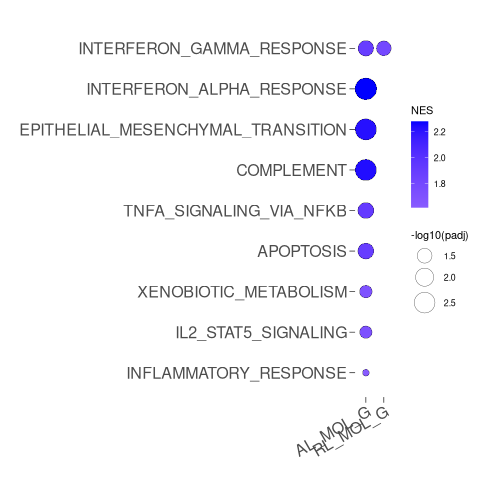

In [155]:
%%R

heatmap_plot <- ggplot(filtered_df, aes(y = pathway, x = condition, size = log_padj, fill = NES)) +
  geom_point(shape = 21, stroke = 0.2, color = "black") +
  scale_fill_gradient2(low = "#c32148", mid = "white", high = "#0000FF", midpoint = 0) +
  scale_size_continuous(range = c(3, 10)) +
  theme_minimal() +
  theme(
    panel.grid = element_blank(),
    axis.text.y = element_text(size = 16, vjust = 0.5),
    axis.text.x = element_text(angle = 30, hjust = 1, size = 16, vjust = 1),
    axis.ticks = element_line(linewidth = 0.3),
    axis.ticks.length = unit(0.2, "cm")
  ) +
  labs(
    x = "", 
    y = "", 
    size = "-log10(padj)", 
    fill = "NES", 
    title = ""
  )

print(heatmap_plot)

ggsave("./figures/GSEA/heatmap_pathway_NES_padj_MOL_only_ordered.png", plot = heatmap_plot, dpi = 300, width = 7.5, height = 8)

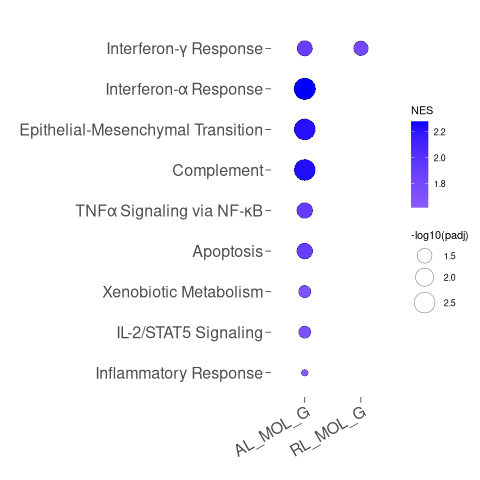

In [156]:
%%R

# Create the heatmap plot
heatmap_plot <- ggplot(filtered_df, aes(y = formatted_pathway, x = condition, size = log_padj, fill = NES)) +
  geom_point(shape = 21, stroke = 0.2, color = "black") +
  scale_fill_gradient2(low = "#c32148", mid = "white", high = "#0000FF", midpoint = 0) +
  scale_size_continuous(range = c(3, 10)) +
  theme_minimal() +
  theme(
    panel.grid = element_blank(),
    axis.text.y = element_text(size = 16, vjust = 0.5),
    axis.text.x = element_text(angle = 30, hjust = 1, size = 16, vjust = 1),
    axis.ticks = element_line(linewidth = 0.3),
    axis.ticks.length = unit(0.2, "cm")
  ) +
  labs(
    x = "", 
    y = "", 
    size = "-log10(padj)", 
    fill = "NES", 
    title = ""
  )

# Print the heatmap
print(heatmap_plot)

# Save the heatmap plot
ggsave("./figures/GSEA/heatmap_pathway_NES_padj_MOL_only_ordered.png", plot = heatmap_plot, dpi = 300, width = 7.5, height = 8)